# Fusion HyperMamba Model

In [1]:
#pip install spectral mat73  einops

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
import os
import math
import random

from scipy.ndimage import rotate

from einops import rearrange
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from scipy import io
import torch.utils.data
import scipy.io as sio
import mat73
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import torch.optim as optim
from torch.utils.data import DataLoader
import copy
import time
import psutil
import os

from sklearn.metrics import confusion_matrix, accuracy_score, cohen_kappa_score
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

m=1

# 0 Upload Data

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#! ls '/content/drive/MyDrive/A02_RemoteSensingData/UHS_2013_DFTC/'

In [4]:
# # Define the path
#path='/content/drive/MyDrive/A02_RemoteSensingData/UHS_2013_DFTC/'

#1.0  Model Building

In [5]:
# Configuration class
class Config:
    def __init__(self, in_channels, num_patches, kernel_size, patch_size, emb_size, dim, depth, heads, dim_head, mlp_ratio, num_classes, dropout, pos_emb_size, class_emb_size, stride, output_dim):  # Set default output_dim to 1
        self.in_channels = in_channels
        self.num_patches = num_patches
        self.kernel_size = kernel_size
        self.patch_size = patch_size
        self.emb_size = emb_size
        self.dim = dim
        self.depth = depth
        self.heads = heads
        self.dim_head = dim_head
        self.mlp_ratio = mlp_ratio
        self.num_classes = num_classes
        self.dropout = dropout
        self.pos_emb_size = pos_emb_size
        self.class_emb_size = class_emb_size
        self.stride = stride
        self.output_dim = output_dim  # Ensure output_dim is a part of the config

### 1.1 Full Architecture Of Forward backward Processing

In [6]:
# Reversed along bands  Method 2

class HSIVimBlock(nn.Module):
    def __init__(self, spatial_dim, num_bands, hidden_dim, output_dim, delta_param_init):
        super(HSIVimBlock, self).__init__()
        self.spatial_dim = spatial_dim
        self.num_bands = num_bands
        self.hidden_dim = hidden_dim

        # LayerNorm over Bands
        self.norm = nn.LayerNorm(num_bands)

        # Adjusted linear layers to handle reversed bands
        self.linear_x = nn.Linear(num_bands, hidden_dim)
        self.linear_z = nn.Linear(num_bands, hidden_dim)

        # Convolution for forward and backward paths
        self.forward_conv1d = nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=3, padding=1)
        self.backward_conv1d = nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=3, padding=1)

        # Trainable matrices and delta parameter
        self.A = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.B = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.delta_param = nn.Parameter(torch.full((hidden_dim,), delta_param_init))

        # Linear layers for final transformation
        self.linear_forward = nn.Linear(hidden_dim, output_dim)
        self.linear_backward = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        Batch, H, W, Bands = x.shape  # Input shape: [Batch, Height, Width, Bands]

        # Reverse bands for z_proj
        x_reversed = torch.flip(x, dims=[-1])  # Reverse along the Bands dimension

        # Flatten spatial dimensions for processing
        x = x.view(Batch, H * W, Bands)  # Shape: [Batch, H*W, Bands]
        z = x_reversed.view(Batch, H * W, Bands)  # Shape: [Batch, H*W, Bands]

        # Apply LayerNorm to the Bands dimension
        x = self.norm(x)  # Shape: [Batch, H*W, Bands]
        z = self.norm(z)  # Shape: [Batch, H*W, Bands]

        # Linear projection to hidden dimensions
        x_proj = self.linear_x(x)  # Shape: [Batch, H*W, hidden_dim]
        z_proj = self.linear_z(z)  # Shape: [Batch, H*W, hidden_dim]

        # Reshape for Conv1d compatibility
        x_proj = x_proj.permute(0, 2, 1)  # Shape: [Batch, hidden_dim, H*W]
        z_proj = z_proj.permute(0, 2, 1)  # Shape: [Batch, hidden_dim, H*W]

        # Reverse the spatial dimension for backward path
        #z_proj_reversed = torch.flip(z_proj, dims=[-1])  # Reverse along the spatial dimension

        # Conv1D processing
        x_forward = F.silu(self.forward_conv1d(x_proj))
        x_backward = F.silu(self.backward_conv1d(z_proj))

        # Apply delta parameter
        delta_expanded = self.delta_param.unsqueeze(0).unsqueeze(2)  # Shape: [1, hidden_dim, 1]

        # Forward and backward SSM processing
        forward_ssm_output = torch.tanh(
            self.forward_conv1d(x_proj) + torch.matmul(self.A, x_proj) + delta_expanded
        )
        backward_ssm_output = torch.tanh(
            self.backward_conv1d(z_proj) + torch.matmul(self.B, z_proj) + delta_expanded
        )

        # Combine forward and backward outputs
        forward_reduced = forward_ssm_output.mean(dim=2)  # Shape: [Batch, hidden_dim]
        backward_reduced = backward_ssm_output.mean(dim=2)  # Shape: [Batch, hidden_dim]

        # Linear layers for final transformation
        y_forward = self.linear_forward(forward_reduced)  # Shape: [Batch, output_dim]
        y_backward = self.linear_backward(backward_reduced)  # Shape: [Batch, output_dim]

        # Combine forward and backward results
        y_combined = y_forward + y_backward  # Shape: [Batch, output_dim]

        return y_combined

In [7]:
# # Version 2.0 This involves reversing the input tensor for the backward path before applying the backward_conv1d operation

# class HSIVimBlock(nn.Module):
#     def __init__(self, spatial_dim, num_bands, hidden_dim, output_dim, delta_param_init):
#         super(HSIVimBlock, self).__init__()
#         input_dim = spatial_dim * spatial_dim * num_bands
#         self.norm = nn.LayerNorm(input_dim)
#         # Initialization with self.hidden_dim
#         self.spatial_dim = spatial_dim
#         self.num_bands = num_bands
#         self.hidden_dim = hidden_dim

#         # LayerNorm is now expecting a flattened feature vector of Bands*H*W elements
#         self.norm = nn.LayerNorm(num_bands * spatial_dim * spatial_dim)

#         # Adjust linear layers according to the new input dimension
#         self.linear_x = nn.Linear(num_bands * spatial_dim * spatial_dim, hidden_dim)
#         self.linear_z = nn.Linear(num_bands * spatial_dim * spatial_dim, hidden_dim)

#         self.forward_conv1d = nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=3, padding=1)
#         self.backward_conv1d = nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=3, padding=1)

#         self.A = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
#         self.B = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
#         #self.C = nn.Parameter(torch.randn(output_dim, hidden_dim))
#         self.delta_param = nn.Parameter(torch.full((hidden_dim,), delta_param_init))

#         self.linear_forward = nn.Linear(hidden_dim, output_dim)
#         self.linear_backward = nn.Linear(hidden_dim, output_dim)

#     def forward(self, x):
#         Batch, H, W, Bands = x.shape  # Correct shape extraction assuming [Batch, Height, Width, Bands]

#         # Correctly reshape for LayerNorm to flatten all spatial and spectral information
#         x = x.reshape(Batch, -1)  # New shape: [Batch, Bands*H*W]

#         # Normalize across the flattened spatial-spectral data
#         x = self.norm(x)

#         # Projection to hidden dimensions
#         x_proj = self.linear_x(x)
#         z_proj = self.linear_z(x)

#         # Ensure correct reshaping for Conv1d compatibility
#         x_proj = x_proj.view(Batch, self.hidden_dim, -1)
#         z_proj = z_proj.view(Batch, self.hidden_dim, -1)

#         # Reverse z_proj for the backward path
#         z_proj_reversed = torch.flip(z_proj, dims=[-1])

#         # Bidirectional Conv1d processing using reversed input for the backward path
#         x_forward = F.silu(self.forward_conv1d(x_proj))
#         x_backward = F.silu(self.backward_conv1d(z_proj_reversed))

#         # Apply delta parameter correctly
#         delta_expanded = self.delta_param.unsqueeze(0).unsqueeze(2)  # Correct shape for broadcasting

#         # SSM processing with delta applied, using the original and reversed inputs for forward and backward paths respectively
#         forward_ssm_output = torch.tanh(self.forward_conv1d(x_proj) + self.A * delta_expanded)
#         backward_ssm_output = torch.tanh(self.backward_conv1d(z_proj_reversed) + self.B * delta_expanded)

#         # Combine forward and backward outputs into a single representation
#         forward_reduced = forward_ssm_output.mean(dim=2)
#         backward_reduced = backward_ssm_output.mean(dim=2)

#         # Combine the reduced forward and backward paths
#         y_forward = self.linear_forward(forward_reduced)
#         y_backward = self.linear_backward(backward_reduced)

#         # Element-wise sum of forward and backward outputs
#         y_combined = y_forward + y_backward

#         # Return the combined output
#         return y_combined


### 1.2 SpatialFeature processing

In [8]:
# New version
class SpatialFeatureProcessing(nn.Module):
    def __init__(self, input_channels):
        super(SpatialFeatureProcessing, self).__init__()
        self.conv_layers = nn.Sequential(
            # First convolutional layer with dilation rate of 1 (standard convolution)
            nn.Conv2d(in_channels=input_channels, out_channels=256, kernel_size=(3, 3), padding=1, dilation=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            # Second convolutional layer with a higher dilation rate to increase the receptive field
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), padding=2, dilation=2),  # Note the increased padding to maintain the spatial dimensions
            nn.ReLU(),
            nn.BatchNorm2d(512)
        )
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Adding global average pooling

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.global_avg_pool(x)  # Apply global average pooling
        x = torch.flatten(x, start_dim=1)  # Flatten all dimensions except batch
        return x

### 1.3 Classifier

In [9]:
class Classifier(nn.Module):
    def __init__(self, in_features, num_classes):
        super(Classifier, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(in_features=1024, out_features=num_classes),
        )

    def forward(self, x):
        x = self.fc_layers(x)
        # Remove softmax here if you're using a loss function that includes it, such as nn.CrossEntropyLoss
        return x


# 1.4 Integrated into Main Model

In [10]:
class HSIClassificationMambaModel(nn.Module):
    def __init__(self, spatial_dim, num_bands, hidden_dim, output_dim, delta_param_init, num_classes):
        super(HSIClassificationMambaModel, self).__init__()
        self.vim_block = HSIVimBlock(spatial_dim, num_bands, hidden_dim, output_dim, delta_param_init)
        self.output_dim = output_dim  # Save output_dim as an attribute of the class

        # Initialize SpatialFeatureProcessing and Classifier here
        # Adjusted to pass 'output_dim' as 'input_channels' to SpatialFeatureProcessing
        self.spatial_processing = SpatialFeatureProcessing(input_channels=output_dim)
        # Assuming the output of SpatialFeatureProcessing matches the in_features expected by Classifier
        self.classifier = Classifier(in_features=512, num_classes=num_classes)

    def forward(self, x):
        x = self.vim_block(x)
        # This is a placeholder. Actual reshaping depends on the output of HSIVimBlock and the input expectation of SpatialFeatureProcessing
        x = x.view(-1, self.output_dim, 1, 1)  # Reshape to include spatial dimensions if needed
        x = self.spatial_processing(x)

        # Flatten the output from spatial processing if it's not already flat
        x = torch.flatten(x, start_dim=1)

        x = self.classifier(x)
        return x

# Instance the Model

In [11]:
# # At The Middel Stage
# # Instantiate the model
# model = HSILidClassificationMambaModel(
#     spatial_dim=7,
#     hsi_num_bands=63,
#     lidar_num_bands=1,
#     hidden_dim=512,
#     output_dim=256,
#     delta_param_init=0.01,
#     num_classes=20
# )

# # Print the model architecture
# print(model)

#3  Data Preparation

In [12]:
# 2.1 Define the class information
class_info = [(1, "Healthy grass", 'training_sample', 198, 'test_sample', 1053,  'total', 1251),
    (2, "Stressed grass",'training_sample', 190, 'test_sample', 1064,  'total', 1254),
    (3, "Synthetic grass", 'training_sample', 192, 'test_sample', 505,  'total', 697),
    (4, "Trees", 'training_sample', 188, 'test_sample', 1058,  'total', 1244),
    (5, "Soil",'training_sample', 186, 'test_sample', 1056,  'total', 1242),
    (6, "Water", 'training_sample', 182, 'test_sample', 141,  'total', 325),
    (7, "Residential", 'training_sample', 196, 'test_sample', 1072,  'total', 1268),
    (8, "Commercial", 'training_sample', 191, 'test_sample', 1053,  'total', 1244),
    (9, "Road", 'training_sample', 193, 'test_sample', 1059,  'total', 1252),
    (10, "Highway", 'training_sample', 191, 'test_sample', 1036,  'total', 1227),
    (11, "Railway", 'training_sample', 181, 'test_sample', 1054,  'total', 1235),
    (12, "Parking lot 1", 'training_sample', 192, 'test_sample', 1041,  'total', 1233),
    (13, "Parking lot 2", 'training_sample', 184, 'test_sample',285,  'total', 469),
    (14, "Tennis court",'training_sample', 181, 'test_sample', 247,  'total', 428),
    (15, "Running track", 'training_sample', 187, 'test_sample', 473,  'total', 660)]

# Create a dictionary to store class number, class name, and class samples
class_dict = {class_number: {"class_name": class_name,
                             'training_sample': training_sample,
                             'test_sample': test_sample,
                             "total_samples": total}
              for class_number, class_name, _, training_sample, _, test_sample, _, total in class_info}

print(class_dict)


{1: {'class_name': 'Healthy grass', 'training_sample': 198, 'test_sample': 1053, 'total_samples': 1251}, 2: {'class_name': 'Stressed grass', 'training_sample': 190, 'test_sample': 1064, 'total_samples': 1254}, 3: {'class_name': 'Synthetic grass', 'training_sample': 192, 'test_sample': 505, 'total_samples': 697}, 4: {'class_name': 'Trees', 'training_sample': 188, 'test_sample': 1058, 'total_samples': 1244}, 5: {'class_name': 'Soil', 'training_sample': 186, 'test_sample': 1056, 'total_samples': 1242}, 6: {'class_name': 'Water', 'training_sample': 182, 'test_sample': 141, 'total_samples': 325}, 7: {'class_name': 'Residential', 'training_sample': 196, 'test_sample': 1072, 'total_samples': 1268}, 8: {'class_name': 'Commercial', 'training_sample': 191, 'test_sample': 1053, 'total_samples': 1244}, 9: {'class_name': 'Road', 'training_sample': 193, 'test_sample': 1059, 'total_samples': 1252}, 10: {'class_name': 'Highway', 'training_sample': 191, 'test_sample': 1036, 'total_samples': 1227}, 11: 

In [13]:
# 2.1 Loads Data
# Load hyperpsectral data
hsi_2013_data=sio.loadmat('2013_IEEE_GRSS_DF_Contest_CASI_349_1905_144.mat')['ans']
print('hsi_2013_data shape:', hsi_2013_data.shape)

# Loader Lidar  data
import mat73
lidar_2013_data = sio.loadmat('2013_IEEE_GRSS_DF_Contest_LiDAR.mat')['LiDAR_data']

print('Lidar_2013_data shape:', lidar_2013_data.shape)

#Load ground truth labels
gt_2013_data=sio.loadmat('GRSS2013.mat')['name']
print('gt_2013_data.shape:', gt_2013_data.shape)

hsi_2013_data shape: (349, 1905, 144)
Lidar_2013_data shape: (349, 1905, 1)
gt_2013_data.shape: (349, 1905)


# Nomralisation Raw Data 

In [14]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Normalization function for HSI and LiDAR data
def normalize_data(data, method="minmax"):
    """
    Normalize hyperspectral or LiDAR data.
    
    Args:
        data (numpy array): Input data array (e.g., HSI or LiDAR).
        method (str): Normalization method, "minmax" or "zscore".
    
    Returns:
        numpy array: Normalized data.
    """
    if method == "minmax":
        # Reshape the data for MinMaxScaler
        scaler = MinMaxScaler()
        flat_data = data.reshape(-1, data.shape[-1])
        normalized_data = scaler.fit_transform(flat_data).reshape(data.shape)
    elif method == "zscore":
        # Standard normalization: zero mean, unit variance
        scaler = StandardScaler()
        flat_data = data.reshape(-1, data.shape[-1])
        normalized_data = scaler.fit_transform(flat_data).reshape(data.shape)
    else:
        raise ValueError("Unsupported normalization method. Use 'minmax' or 'zscore'.")
    
    return normalized_data

# Load hyperspectral data
hsi_2013_data = sio.loadmat('2013_IEEE_GRSS_DF_Contest_CASI_349_1905_144.mat')['ans']
print('HSI data shape:', hsi_2013_data.shape)

# Normalize HSI data
hsi_2013_data_normalized = normalize_data(hsi_2013_data, method="minmax")
print('HSI normalized shape:', hsi_2013_data_normalized.shape)

# Load LiDAR data
lidar_2013_data = sio.loadmat('2013_IEEE_GRSS_DF_Contest_LiDAR.mat')['LiDAR_data']
print('LiDAR data shape:', lidar_2013_data.shape)

# Normalize LiDAR data
# Since LiDAR has a single band, we normalize over the first two dimensions only
lidar_min = np.min(lidar_2013_data)
lidar_max = np.max(lidar_2013_data)
lidar_2013_data_normalized = (lidar_2013_data - lidar_min) / (lidar_max - lidar_min)
print('LiDAR normalized shape:', lidar_2013_data_normalized.shape)

HSI data shape: (349, 1905, 144)
HSI normalized shape: (349, 1905, 144)
LiDAR data shape: (349, 1905, 1)
LiDAR normalized shape: (349, 1905, 1)


# Random Dataset 

In [15]:
# 2.2 Samples Extraction

# Define patch size and stride
patch_size = m
stride = 1

# Create an empty list to store patches and labels
hsi_samples = []
lidar_samples = []
labels = []

# Initialize a dictionary to store class count
class_count = {i: 0 for i in class_dict.keys()}

# Function to check if all classes have the required number of samples
def all_classes_completed(class_count, class_dict):
    return all(class_count[class_num] == class_dict[class_num]["total_samples"] for class_num in class_dict.keys())

while not all_classes_completed(class_count, class_dict):
    # Loop through the ground truth data
    for label in class_dict.keys():
        # Get the coordinates of the ground truth pixels
        #coords = np.argwhere((gt_2013_data == label) & (mask > 0))
        coords = np.argwhere(gt_2013_data == label)

        # Shuffle the coordinates to randomize the patch extraction
        np.random.shuffle(coords)

        for coord in coords:
            i, j = coord
            # Calculate the patch indices
            i_start, i_end = i - patch_size // 2, i + patch_size // 2 + 1
            j_start, j_end = j - patch_size // 2, j + patch_size // 2 + 1

            # Check if the indices are within the bounds of the HSI data
            if i_start >= 0 and i_end <= hsi_2013_data.shape[0] and j_start >= 0 and j_end <= hsi_2013_data.shape[1]:
                # Extract the patch
                hsi_patch = hsi_2013_data[i_start:i_end, j_start:j_end, :]

                # Extract the LiDAR patch
                lidar_patch = lidar_2013_data[i_start:i_end, j_start:j_end, :]

                # If the class count is less than the required samples
                if class_count[label] < class_dict[label]["total_samples"]:
                    # Append the patch and its label to the list
                    hsi_samples.append(hsi_patch)
                    lidar_samples.append(lidar_patch)
                    labels.append(label)
                    class_count[label] += 1

                    # If all classes have the required number of samples, exit the loop
                    if all_classes_completed(class_count, class_dict):
                        break

# Convert the list of patches and labels into arrays
hsi_samples = np.array(hsi_samples)
lidar_samples = np.array(lidar_samples)
labels = np.array(labels)
print('hsi_samples shape:', hsi_samples.shape)
print('lidar_samples shape:', lidar_samples.shape)
print('labels shape:', labels.shape)

hsi_samples shape: (15029, 1, 1, 144)
lidar_samples shape: (15029, 1, 1, 1)
labels shape: (15029,)


In [257]:
# Create training_samples_dict based on class_dict
training_samples_dict = {class_num: class_info["training_sample"] for class_num, class_info in class_dict.items()}

# Assuming `hsi_samples`, `lidar_samples`, and `labels` have been previously defined
# Convert the list of patches and labels into arrays if they aren't already
hsi_samples = np.array(hsi_samples)
lidar_samples = np.array(lidar_samples)
labels = np.array(labels)

# Create lists to store training and test samples and labels
hsi_training_samples, lidar_training_samples, training_labels = [], [], []
hsi_test_samples, lidar_test_samples, test_labels = [], [], []

# Split samples into training and test sets based on the desired number of training samples
for label, train_samples in training_samples_dict.items():
    # Get indices of the current class
    class_indices = np.where(labels == label)[0]

    # Randomly shuffle the indices
    np.random.shuffle(class_indices)

    # Split the indices into training and test set indices
    train_indices = class_indices[:train_samples]
    test_indices = class_indices[train_samples:]

    # Add training samples and labels for the current class
    hsi_training_samples.extend(hsi_samples[train_indices])
    lidar_training_samples.extend(lidar_samples[train_indices])
    training_labels.extend(labels[train_indices])

    # Add test samples and labels for the current class
    hsi_test_samples.extend(hsi_samples[test_indices])
    lidar_test_samples.extend(lidar_samples[test_indices])
    test_labels.extend(labels[test_indices])

# Convert lists back to numpy arrays
hsi_train_samples = np.array(hsi_training_samples)
lidar_train_samples = np.array(lidar_training_samples)
training_labels = np.array(training_labels)

hsi_test_samples = np.array(hsi_test_samples)
lidar_test_samples = np.array(lidar_test_samples)
test_labels = np.array(test_labels)

# Print shapes to verify
print('hsi_training_samples shape:', hsi_train_samples.shape)
print('lidar_training_samples shape:', lidar_train_samples.shape)
print('training_labels shape:', training_labels.shape)

print('hsi_test_samples shape:', hsi_test_samples.shape)
print('lidar_test_samples shape:', lidar_test_samples.shape)
print('test_labels shape:', test_labels.shape)


hsi_training_samples shape: (2832, 1, 1, 144)
lidar_training_samples shape: (2832, 1, 1, 1)
training_labels shape: (2832,)
hsi_test_samples shape: (12197, 1, 1, 144)
lidar_test_samples shape: (12197, 1, 1, 1)
test_labels shape: (12197,)


# Defined Location Train smaples , Same as Danfeng 

In [258]:
# Generate a list of indices for the 144 bands
full_bands = list(range(144))

# Print the list of band indices
print("Band Indices:", full_bands)
band_indices=full_bands


# Extract the corresponding bands from the augmented training samples
selected_hsi_train_samples = hsi_train_samples[:,:,:, band_indices]
selected_hsi_test_samples = hsi_test_samples[:,:,:, band_indices]
selected_lidar_train =  lidar_train_samples
selected_lidar_test = lidar_test_samples
print('selected_hsi_train_samples  shape:', selected_hsi_train_samples .shape)
print('selected_hsi_test_sample shape:', selected_hsi_test_samples.shape)
print('selected_lidar_train shape:', selected_lidar_train.shape)
print('selected_lidar_test shape:', selected_lidar_test.shape)

# #Adding LiDAR Data to Reduced bands HSI Data,concatenate the data along axis 3
# Concatenate along axis 3 (the band/channel axis)
selected_hsi_lidar_train_samples = np.concatenate((selected_hsi_train_samples, selected_lidar_train), axis=3)
selected_hsi_lidar_test_samples = np.concatenate((selected_hsi_test_samples, selected_lidar_test), axis=3)

# Check the shapes of the concatenated samples
print('selected_hsi_lidar_train_samples shape:', selected_hsi_lidar_train_samples.shape)
print('hsselected_hsi_lidar_test_samples shape:', selected_hsi_lidar_test_samples.shape)


X_train=selected_hsi_lidar_train_samples
X_test=selected_hsi_lidar_test_samples
y_train=training_labels
y_test=test_labels

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

Band Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143]
selected_hsi_train_samples  shape: (2832, 1, 1, 144)
selected_hsi_test_sample shape: (12197, 1, 1, 144)
selected_lidar_train shape: (2832, 1, 1, 1)
selected_lidar_test shape: (12197, 1, 1, 1)
selected_hsi_lidar_train_samples shape: (2832, 1, 1, 145)
hsselected_hsi_lidar_test_samples shape: (12197, 1, 1, 145)
X_train shape: (2832, 1, 1, 145)
X_test shape: (12197, 1, 1, 145)

# Data method 2, Only HSI 

In [259]:
# X_train=selected_hsi_train_samples
# X_test=selected_hsi_test_samples
# y_train=training_labels
# y_test=test_labels


# Data method 3, Only HSI 

In [260]:
# # Data method 2, Only LiDAR
# X_train=  lidar_train_samples
# X_test = lidar_test_samples
# y_train=training_labels
# y_test=test_labels

In [261]:
# import numpy as np
# from scipy.ndimage import rotate

def augment_training_data(hsi_training_data, training_labels, rotations=[45, 90, 135], flip_up_down=True, flip_left_right=True):
    augmented_hsi = []
    augmented_labels = []

    for hsi, label in zip(hsi_training_data, training_labels):
        # Original data
        augmented_hsi.append(hsi)
        augmented_labels.append(label)

        # Rotations
        for angle in rotations:
            hsi_rotated = rotate(hsi, angle, axes=(0, 1), reshape=False, mode='nearest')
            augmented_hsi.append(hsi_rotated)
            augmented_labels.append(label)

        # Flip up-down
        if flip_up_down:
            hsi_flipped_ud = np.flipud(hsi)
            augmented_hsi.append(hsi_flipped_ud)
            augmented_labels.append(label)

        # Flip left-right
        if flip_left_right:
            hsi_flipped_lr = np.flipud(hsi)
            augmented_hsi.append(hsi_flipped_lr)
            augmented_labels.append(label)

    return np.array(augmented_hsi), np.array(augmented_labels)

# Augmenting the training samples
augmented_hsi_training_samples, augmented_training_labels = augment_training_data(X_train,y_train)

# Print shapes to verify the augmented training data
print('Augmented HSI training samples shape:', augmented_hsi_training_samples.shape)
print('Augmented training labels shape:', augmented_training_labels.shape)

Augmented HSI training samples shape: (16992, 1, 1, 145)
Augmented training labels shape: (16992,)


In [262]:
# import numpy as np
# import torch
# from torch.utils.data import TensorDataset, DataLoader
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler

# Split the augmented training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    augmented_hsi_training_samples, augmented_training_labels, test_size=0.1, random_state=42, stratify=augmented_training_labels
)

print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('y_train shape:', y_train.shape)
print('y_val shape:', y_val.shape)

print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

# Store the data shapes for model
original_train_shape = X_train.shape  # (samples, height, width, channels)
original_val_shape = X_val.shape
original_test_shape = X_test.shape

# Reshape for standardization
X_train_reshaped = X_train.reshape(-1, original_train_shape[1]*original_train_shape[2]*original_train_shape[3])
X_val_reshaped = X_val.reshape(-1, original_val_shape[1]*original_val_shape[2]*original_val_shape[3])
X_test_reshaped = X_test.reshape(-1, original_test_shape[1]*original_test_shape[2]*original_test_shape[3])

# Standardize
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train_reshaped)
X_val_standardized = scaler.transform(X_val_reshaped)
X_test_standardized = scaler.transform(X_test_reshaped)

# Reshape back to original 4D shape
X_train = X_train_standardized.reshape(original_train_shape)
X_val = X_val_standardized.reshape(original_val_shape)
X_test = X_test_standardized.reshape(original_test_shape)

# Check the reshaped arrays
print("After standardization:")
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

# Convert the split datasets to tensor datasets
train_dataset = TensorDataset(torch.tensor(X_train.astype(np.float32)), torch.tensor(y_train).long())
val_dataset = TensorDataset(torch.tensor(X_val.astype(np.float32)), torch.tensor(y_val).long())
test_dataset = TensorDataset(torch.tensor(X_test.astype(np.float32)), torch.tensor(y_test).long())

# Create DataLoader instances for training, validation, and testing
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

X_train shape: (15292, 1, 1, 145)
X_val shape: (1700, 1, 1, 145)
y_train shape: (15292,)
y_val shape: (1700,)
X_test shape: (12197, 1, 1, 145)
y_test shape: (12197,)
After standardization:
X_train shape: (15292, 1, 1, 145)
X_val shape: (1700, 1, 1, 145)
X_test shape: (12197, 1, 1, 145)


# 5.0 Training Model Memeory and Time calcualtion

In [263]:
# Before the training loop, to record the initial memory usage (GPU)
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()  # Reset peak memory stats at the start
    initial_memory = torch.cuda.memory_allocated()
    print(f"Initial Memory Allocated: {initial_memory / 1e6} MB")
    
# 1.0 Training Model in GPU for HSI loader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#model = HSIClassificationMambaModel(
#    spatial_dim=7, num_bands=145, hidden_dim=256, output_dim=128, delta_param_init=0.01, num_classes=15
#)

model = HSIClassificationMambaModel(
    spatial_dim=m, num_bands=145, hidden_dim=512, output_dim=256, delta_param_init=0.01, num_classes=15
)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.000001)

epochs = 100
best_val_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())
patience = 30

start_time = time.time()  # Step 2: Record the start time

for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device) # Move the data into device
        optimizer.zero_grad()
        labels -= 1
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    epoch_train_loss = running_train_loss / len(train_loader.dataset)

    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device) # Move the data into device
            outputs = model(inputs)
            labels -= 1
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

        epoch_val_loss = val_running_loss / len(val_loader.dataset)

    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

    if epoch_val_loss < best_val_loss:
        print(f'Validation Loss Decreased({best_val_loss:.6f}--->{epoch_val_loss:.6f}) \t Saving The Model')
        best_val_loss = epoch_val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1

    if no_improve_epochs > patience:
        print('Early stopping!')
        model.load_state_dict(best_model_wts)
        break

end_time = time.time()  # Step 3: Record the end time
total_time = end_time - start_time  # Step 4: Calculate total training time

print(f'Finished training. Total training time: {total_time:.2f} seconds')  # Print the total training time

Initial Memory Allocated: 298.286592 MB
Epoch [1/100], Train Loss: 0.0757, Val Loss: 0.0669
Validation Loss Decreased(inf--->0.066889) 	 Saving The Model
Epoch [2/100], Train Loss: 0.0603, Val Loss: 0.0539
Validation Loss Decreased(0.066889--->0.053876) 	 Saving The Model
Epoch [3/100], Train Loss: 0.0502, Val Loss: 0.0453
Validation Loss Decreased(0.053876--->0.045324) 	 Saving The Model
Epoch [4/100], Train Loss: 0.0429, Val Loss: 0.0388
Validation Loss Decreased(0.045324--->0.038779) 	 Saving The Model
Epoch [5/100], Train Loss: 0.0374, Val Loss: 0.0339
Validation Loss Decreased(0.038779--->0.033885) 	 Saving The Model
Epoch [6/100], Train Loss: 0.0329, Val Loss: 0.0298
Validation Loss Decreased(0.033885--->0.029785) 	 Saving The Model
Epoch [7/100], Train Loss: 0.0293, Val Loss: 0.0263
Validation Loss Decreased(0.029785--->0.026324) 	 Saving The Model
Epoch [8/100], Train Loss: 0.0263, Val Loss: 0.0234
Validation Loss Decreased(0.026324--->0.023446) 	 Saving The Model
Epoch [9/100]

Epoch [75/100], Train Loss: 0.0001, Val Loss: 0.0001
Validation Loss Decreased(0.000069--->0.000065) 	 Saving The Model
Epoch [76/100], Train Loss: 0.0002, Val Loss: 0.0001
Validation Loss Decreased(0.000065--->0.000055) 	 Saving The Model
Epoch [77/100], Train Loss: 0.0001, Val Loss: 0.0001
Validation Loss Decreased(0.000055--->0.000053) 	 Saving The Model
Epoch [78/100], Train Loss: 0.0001, Val Loss: 0.0001
Epoch [79/100], Train Loss: 0.0001, Val Loss: 0.0000
Validation Loss Decreased(0.000053--->0.000047) 	 Saving The Model
Epoch [80/100], Train Loss: 0.0001, Val Loss: 0.0000
Validation Loss Decreased(0.000047--->0.000045) 	 Saving The Model
Epoch [81/100], Train Loss: 0.0001, Val Loss: 0.0000
Validation Loss Decreased(0.000045--->0.000037) 	 Saving The Model
Epoch [82/100], Train Loss: 0.0001, Val Loss: 0.0000
Epoch [83/100], Train Loss: 0.0001, Val Loss: 0.0000
Validation Loss Decreased(0.000037--->0.000032) 	 Saving The Model
Epoch [84/100], Train Loss: 0.0001, Val Loss: 0.0001
E

In [264]:
# After the training loop, to record the final memory usage (GPU)
if torch.cuda.is_available():
    # Calculate the peak memory usage during the training
    peak_memory = torch.cuda.max_memory_allocated()
    # Calculate the final memory usage after training
    final_memory = torch.cuda.memory_allocated()

 # Calculate the memory used during the training
    memory_used = final_memory - initial_memory

    # Reset memory stats for future measurements
    torch.cuda.reset_peak_memory_stats()

    print(f"Peak Memory Allocated During Training: {peak_memory / 1e6} MB")
    print(f"Final Memory Allocated: {final_memory / 1e6} MB")
    # Adding the new line here to show memory used
    print(f"Memory Used During Training: {memory_used / 1e6} MB")

Peak Memory Allocated During Training: 319.532032 MB
Final Memory Allocated: 297.859072 MB
Memory Used During Training: -0.42752 MB


### Save the modle

In [265]:
# Assuming 'model' is your instance of HSIClassificationModel or any other model
replacement_value = m

# Dynamically construct the file name
model_save_path = 'Early_fusionp$num$_UH2013_model_state_dict.pth'
model_save_path = model_save_path.replace('$num$', str(replacement_value))

# Save the model state dictionary to the updated path
torch.save(model.state_dict(), model_save_path)

### Claculte th test time

In [266]:
# Save the model
#model_save_path =  'Early_fusionp$num$_trento_model_state_dict.pth'
torch.save(model.state_dict(), model_save_path)
#replacement_value = m  # Replace "m" with this number dynamically

# Replace "$m$" with the integer value
#model_save_path = model_save_path.replace('$num$', str(replacement_value))


print(f'Model saved to {model_save_path}')

# Load the model (make sure to initialize the model architecture first)
model.load_state_dict(torch.load(model_save_path,weights_only=False))
model.to(device)

# Ensure the model is in evaluation mode
model.eval()

# Store predictions and actual labels
predictions = []
actual_labels = []

start_time = time.time()  # Start timing

with torch.no_grad():
    for hsi_patches, labels in test_loader:
        # Move data to the appropriate device
        hsi_patches = hsi_patches.to(device)
        labels -= 1  # Adjust labels if necessary

        # Forward pass
        outputs = model(hsi_patches)

        # Get predictions
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        actual_labels.extend(labels.cpu().numpy())

end_time = time.time()  # End timing
test_time = end_time - start_time  # Calculate the test time

# Optionally, calculate accuracy or other metrics using predictions and actual_labels

# Convert lists to NumPy arrays for easier manipulation
predictions_array = np.array(predictions)
actual_labels_array = np.array(actual_labels)

# Overall Accuracy
oa = accuracy_score(actual_labels_array, predictions_array)

# Confusion Matrix
cm = confusion_matrix(actual_labels_array, predictions_array)
# Calculate per-class accuracy from the confusion matrix
class_accuracy = cm.diagonal() / cm.sum(axis=1)
# Average Accuracy
aa = np.mean(class_accuracy)

# Kappa Coefficient
kappa = cohen_kappa_score(actual_labels_array, predictions_array)

print(f'Overall Accuracy (OA): {oa:.4f}')
print(f'Average Accuracy (AA): {aa:.4f}')
print(f'Kappa Coefficient: {kappa:.4f}')
print(f'Test time: {test_time:.2f} seconds')  # Print the test time

for i, acc in enumerate(class_accuracy): print(f'Class {i+1} Accuracy: {acc:.4f}')

Model saved to Early_fusionp1_UH2013_model_state_dict.pth
Overall Accuracy (OA): 0.9560
Average Accuracy (AA): 0.9570
Kappa Coefficient: 0.9522
Test time: 0.95 seconds
Class 1 Accuracy: 0.9734
Class 2 Accuracy: 0.9803
Class 3 Accuracy: 0.9980
Class 4 Accuracy: 0.9896
Class 5 Accuracy: 0.9877
Class 6 Accuracy: 0.9930
Class 7 Accuracy: 0.9515
Class 8 Accuracy: 0.9554
Class 9 Accuracy: 0.9046
Class 10 Accuracy: 0.9624
Class 11 Accuracy: 0.9099
Class 12 Accuracy: 0.9260
Class 13 Accuracy: 0.8316
Class 14 Accuracy: 0.9960
Class 15 Accuracy: 0.9958


# Updated Reversed Data stream in the code Test 

In [241]:
# p1( HSI+Lidar) 
Finished training. Total training time: 321.00 seconds
    Model saved to Early_fusionp1_UH2013_model_state_dict.pth
Overall Accuracy (OA): 0.9560
Average Accuracy (AA): 0.9570
Kappa Coefficient: 0.9522
Test time: 0.95 seconds
Class 1 Accuracy: 0.9734
Class 2 Accuracy: 0.9803
Class 3 Accuracy: 0.9980
Class 4 Accuracy: 0.9896
Class 5 Accuracy: 0.9877
Class 6 Accuracy: 0.9930
Class 7 Accuracy: 0.9515
Class 8 Accuracy: 0.9554
Class 9 Accuracy: 0.9046
Class 10 Accuracy: 0.9624
Class 11 Accuracy: 0.9099
Class 12 Accuracy: 0.9260
Class 13 Accuracy: 0.8316
Class 14 Accuracy: 0.9960
Class 15 Accuracy: 0.9958


In [ ]:
# p3( HSI+Lidar) 
Finished training. Total training time: 305.58 seconds
Model saved to Early_fusionp3_UH2013_model_state_dict.pth
Overall Accuracy (OA): 0.9954
Average Accuracy (AA): 0.9960
Kappa Coefficient: 0.9950
Test time: 1.13 seconds
Class 1 Accuracy: 0.9991
Class 2 Accuracy: 0.9953
Class 3 Accuracy: 1.0000
Class 4 Accuracy: 0.9981
Class 5 Accuracy: 1.0000
Class 6 Accuracy: 1.0000
Class 7 Accuracy: 0.9925
Class 8 Accuracy: 0.9981
Class 9 Accuracy: 0.9792
Class 10 Accuracy: 0.9971
Class 11 Accuracy: 0.9943
Class 12 Accuracy: 0.9962
Class 13 Accuracy: 0.9895
Class 14 Accuracy: 1.0000
Class 15 Accuracy: 1.0000

In [ ]:
# p5( HSI+Lidar) 
Finished training. Total training time: 338.37 seconds
Model saved to Early_fusionp5_UH2013_model_state_dict.pth
Overall Accuracy (OA): 0.9986
Average Accuracy (AA): 0.9989
Kappa Coefficient: 0.9985
Test time: 1.27 seconds
Class 1 Accuracy: 1.0000
Class 2 Accuracy: 0.9953
Class 3 Accuracy: 1.0000
Class 4 Accuracy: 1.0000
Class 5 Accuracy: 1.0000
Class 6 Accuracy: 1.0000
Class 7 Accuracy: 1.0000
Class 8 Accuracy: 1.0000
Class 9 Accuracy: 0.9906
Class 10 Accuracy: 1.0000
Class 11 Accuracy: 0.9981
Class 12 Accuracy: 1.0000
Class 13 Accuracy: 1.0000
Class 14 Accuracy: 1.0000
Class 15 Accuracy: 1.0000

In [ ]:
# p7( HSI+Lidar) 
Finished training. Total training time: 414.73 seconds
    Model saved to Early_fusionp7_UH2013_model_state_dict.pth
Overall Accuracy (OA): 0.9993
Average Accuracy (AA): 0.9995
Kappa Coefficient: 0.9993
Test time: 1.67 seconds
Class 1 Accuracy: 1.0000
Class 2 Accuracy: 1.0000
Class 3 Accuracy: 1.0000
Class 4 Accuracy: 1.0000
Class 5 Accuracy: 0.9981
Class 6 Accuracy: 1.0000
Class 7 Accuracy: 1.0000
Class 8 Accuracy: 1.0000
Class 9 Accuracy: 0.9943
Class 10 Accuracy: 1.0000
Class 11 Accuracy: 1.0000
Class 12 Accuracy: 1.0000
Class 13 Accuracy: 1.0000
Class 14 Accuracy: 1.0000
Class 15 Accuracy: 1.0000

In [ ]:
# p9( HSI+Lidar) 
Finished training. Total training time: 532.42 seconds
    Model saved to Early_fusionp9_UH2013_model_state_dict.pth
Overall Accuracy (OA): 0.9989
Average Accuracy (AA): 0.9992
Kappa Coefficient: 0.9988
Test time: 2.10 seconds
Class 1 Accuracy: 0.9924
Class 2 Accuracy: 1.0000
Class 3 Accuracy: 1.0000
Class 4 Accuracy: 0.9991
Class 5 Accuracy: 1.0000
Class 6 Accuracy: 1.0000
Class 7 Accuracy: 1.0000
Class 8 Accuracy: 1.0000
Class 9 Accuracy: 0.9962
Class 10 Accuracy: 1.0000
Class 11 Accuracy: 1.0000
Class 12 Accuracy: 1.0000
Class 13 Accuracy: 1.0000
Class 14 Accuracy: 1.0000
Class 15 Accuracy: 1.0000

In [ ]:
# p11( HSI+Lidar) 
Finished training. Total training time: 685.01 seconds
    Model saved to Early_fusionp11_UH2013_model_state_dict.pth
Overall Accuracy (OA): 0.9971
Average Accuracy (AA): 0.9978
Kappa Coefficient: 0.9969
Test time: 2.58 seconds
Class 1 Accuracy: 0.9905
Class 2 Accuracy: 1.0000
Class 3 Accuracy: 1.0000
Class 4 Accuracy: 1.0000
Class 5 Accuracy: 1.0000
Class 6 Accuracy: 1.0000
Class 7 Accuracy: 0.9916
Class 8 Accuracy: 0.9867
Class 9 Accuracy: 1.0000
Class 10 Accuracy: 1.0000
Class 11 Accuracy: 1.0000
Class 12 Accuracy: 0.9981
Class 13 Accuracy: 1.0000
Class 14 Accuracy: 1.0000
Class 15 Accuracy: 1.0000

In [ ]:
# p13( HSI+Lidar) 
Finished training. Total training time: 896.55 seconds
    Model saved to Early_fusionp13_UH2013_model_state_dict.pth
Overall Accuracy (OA): 0.9958
Average Accuracy (AA): 0.9968
Kappa Coefficient: 0.9955
Test time: 3.30 seconds
Class 1 Accuracy: 0.9810
Class 2 Accuracy: 1.0000
Class 3 Accuracy: 1.0000
Class 4 Accuracy: 1.0000
Class 5 Accuracy: 1.0000
Class 6 Accuracy: 1.0000
Class 7 Accuracy: 1.0000
Class 8 Accuracy: 0.9744
Class 9 Accuracy: 1.0000
Class 10 Accuracy: 1.0000
Class 11 Accuracy: 1.0000
Class 12 Accuracy: 0.9962
Class 13 Accuracy: 1.0000
Class 14 Accuracy: 1.0000
Class 15 Accuracy: 1.0000

In [ ]:
# p15( HSI+Lidar) 
Finished training. Total training time: 1036.45 seconds
    Model saved to Early_fusionp15_UH2013_model_state_dict.pth
Overall Accuracy (OA): 0.9957
Average Accuracy (AA): 0.9967
Kappa Coefficient: 0.9953
Test time: 4.30 seconds
Class 1 Accuracy: 0.9972
Class 2 Accuracy: 0.9897
Class 3 Accuracy: 1.0000
Class 4 Accuracy: 1.0000
Class 5 Accuracy: 1.0000
Class 6 Accuracy: 1.0000
Class 7 Accuracy: 0.9935
Class 8 Accuracy: 0.9744
Class 9 Accuracy: 1.0000
Class 10 Accuracy: 1.0000
Class 11 Accuracy: 1.0000
Class 12 Accuracy: 0.9952
Class 13 Accuracy: 1.0000
Class 14 Accuracy: 1.0000
Class 15 Accuracy: 1.0000

In [ ]:
# p17( HSI+Lidar) 
Finished training. Total training time: 1216.32 seconds
Model saved to Early_fusionp17_UH2013_model_state_dict.pth
Overall Accuracy (OA): 0.9967
Average Accuracy (AA): 0.9975
Kappa Coefficient: 0.9964
Test time: 4.90 seconds
Class 1 Accuracy: 0.9981
Class 2 Accuracy: 0.9915
Class 3 Accuracy: 1.0000
Class 4 Accuracy: 0.9934
Class 5 Accuracy: 1.0000
Class 6 Accuracy: 1.0000
Class 7 Accuracy: 0.9907
Class 8 Accuracy: 1.0000
Class 9 Accuracy: 0.9906
Class 10 Accuracy: 1.0000
Class 11 Accuracy: 1.0000
Class 12 Accuracy: 0.9981
Class 13 Accuracy: 1.0000
Class 14 Accuracy: 1.0000
Class 15 Accuracy: 1.0000

# Original Code Test 

In [ ]:
#Only LiDAR


In [ ]:
# Only HSI
Model saved to Early_fusionp11_UH2013_model_state_dict.pth
Overall Accuracy (OA): 0.9828
Average Accuracy (AA): 0.9855
Kappa Coefficient: 0.9813
Test time: 1.59 seconds
Class 1 Accuracy: 0.9782
Class 2 Accuracy: 0.9981
Class 3 Accuracy: 1.0000
Class 4 Accuracy: 0.9972
Class 5 Accuracy: 1.0000
Class 6 Accuracy: 1.0000
Class 7 Accuracy: 0.9701
Class 8 Accuracy: 0.9582
Class 9 Accuracy: 0.9518
Class 10 Accuracy: 0.9923
Class 11 Accuracy: 0.9867
Class 12 Accuracy: 0.9750
Class 13 Accuracy: 0.9754
Class 14 Accuracy: 1.0000
Class 15 Accuracy: 1.0000

# Defined Location Trainign Samples  Experiments 

In [ ]:
Model saved to Early_fusionp11_UH2013_model_state_dict.pth
Overall Accuracy (OA): 0.9759
Average Accuracy (AA): 0.9777
Kappa Coefficient: 0.9738
Test time: 1.63 seconds
Class 1 Accuracy: 0.9753
Class 2 Accuracy: 0.9944
Class 3 Accuracy: 1.0000
Class 4 Accuracy: 0.9991
Class 5 Accuracy: 1.0000
Class 6 Accuracy: 0.9860
Class 7 Accuracy: 0.9767
Class 8 Accuracy: 0.9658
Class 9 Accuracy: 0.9471
Class 10 Accuracy: 0.9759
Class 11 Accuracy: 0.9554
Class 12 Accuracy: 0.9491
Class 13 Accuracy: 0.9404
Class 14 Accuracy: 1.0000
Class 15 Accuracy: 1.0000

# Random Trainign samples Test 

In [ ]:
Finished training. Total training time: 521.93 seconds
Model saved to Early_fusionp1_UH2013_model_state_dict.pth
Overall Accuracy (OA): 0.9711
Average Accuracy (AA): 0.9740
Kappa Coefficient: 0.9687
Test time: 0.69 seconds
Class 1 Accuracy: 0.9744
Class 2 Accuracy: 0.9850
Class 3 Accuracy: 1.0000
Class 4 Accuracy: 0.9915
Class 5 Accuracy: 0.9877
Class 6 Accuracy: 0.9930
Class 7 Accuracy: 0.9608
Class 8 Accuracy: 0.9801
Class 9 Accuracy: 0.9433
Class 10 Accuracy: 0.9846
Class 11 Accuracy: 0.9288
Class 12 Accuracy: 0.9500
Class 13 Accuracy: 0.9333
Class 14 Accuracy: 1.0000
Class 15 Accuracy: 0.9979

In [ ]:
Finished training. Total training time: 249.86 seconds
Model saved to Early_fusionp3_UH2013_model_state_dict.pth
Overall Accuracy (OA): 0.9875
Average Accuracy (AA): 0.9891
Kappa Coefficient: 0.9865
Test time: 0.72 seconds
Class 1 Accuracy: 1.0000
Class 2 Accuracy: 0.9925
Class 3 Accuracy: 0.9980
Class 4 Accuracy: 0.9744
Class 5 Accuracy: 1.0000
Class 6 Accuracy: 1.0000
Class 7 Accuracy: 0.9739
Class 8 Accuracy: 0.9839
Class 9 Accuracy: 0.9641
Class 10 Accuracy: 0.9961
Class 11 Accuracy: 0.9867
Class 12 Accuracy: 0.9923
Class 13 Accuracy: 0.9789
Class 14 Accuracy: 0.9960
Class 15 Accuracy: 1.0000

In [180]:
Finished training. Total training time: 323.01 seconds
Model saved to Early_fusionp5_UH2013_model_state_dict.pth
Overall Accuracy (OA): 0.9930
Average Accuracy (AA): 0.9940
Kappa Coefficient: 0.9924
Test time: 0.77 seconds
Class 1 Accuracy: 1.0000
Class 2 Accuracy: 0.9925
Class 3 Accuracy: 1.0000
Class 4 Accuracy: 0.9991
Class 5 Accuracy: 0.9991
Class 6 Accuracy: 1.0000
Class 7 Accuracy: 0.9851
Class 8 Accuracy: 0.9801
Class 9 Accuracy: 0.9877
Class 10 Accuracy: 0.9903
Class 11 Accuracy: 0.9915
Class 12 Accuracy: 0.9981
Class 13 Accuracy: 0.9860
Class 14 Accuracy: 1.0000
Class 15 Accuracy: 1.0000

In [ ]:
Finished training. Total training time: 311.71 seconds
Model saved to Early_fusionp7_UH2013_model_state_dict.pth
Overall Accuracy (OA): 0.9899
Average Accuracy (AA): 0.9904
Kappa Coefficient: 0.9891
Test time: 0.94 seconds
Class 1 Accuracy: 0.9981
Class 2 Accuracy: 0.9934
Class 3 Accuracy: 1.0000
Class 4 Accuracy: 0.9972
Class 5 Accuracy: 1.0000
Class 6 Accuracy: 1.0000
Class 7 Accuracy: 0.9795
Class 8 Accuracy: 0.9896
Class 9 Accuracy: 0.9707
Class 10 Accuracy: 0.9903
Class 11 Accuracy: 0.9867
Class 12 Accuracy: 0.9885
Class 13 Accuracy: 0.9614
Class 14 Accuracy: 1.0000
Class 15 Accuracy: 1.0000

In [ ]:
Finished training. Total training time: 397.16 seconds
Model saved to Early_fusionp9_UH2013_model_state_dict.pth
Overall Accuracy (OA): 0.9891
Average Accuracy (AA): 0.9909
Kappa Coefficient: 0.9882
Test time: 1.05 seconds
Class 1 Accuracy: 0.9858
Class 2 Accuracy: 0.9981
Class 3 Accuracy: 1.0000
Class 4 Accuracy: 0.9991
Class 5 Accuracy: 1.0000
Class 6 Accuracy: 1.0000
Class 7 Accuracy: 0.9832
Class 8 Accuracy: 0.9725
Class 9 Accuracy: 0.9783
Class 10 Accuracy: 0.9952
Class 11 Accuracy: 0.9839
Class 12 Accuracy: 0.9817
Class 13 Accuracy: 0.9860
Class 14 Accuracy: 1.0000
Class 15 Accuracy: 1.0000
1


In [ ]:
Finished training. Total training time: 304.01 seconds
Model saved to Early_fusionp11_UH2013_model_state_dict.pth
Overall Accuracy (OA): 0.9871
Average Accuracy (AA): 0.9894
Kappa Coefficient: 0.9860
Test time: 1.21 seconds
Class 1 Accuracy: 0.9839
Class 2 Accuracy: 0.9981
Class 3 Accuracy: 1.0000
Class 4 Accuracy: 0.9991
Class 5 Accuracy: 1.0000
Class 6 Accuracy: 1.0000
Class 7 Accuracy: 0.9841
Class 8 Accuracy: 0.9715
Class 9 Accuracy: 0.9603
Class 10 Accuracy: 0.9923
Class 11 Accuracy: 0.9886
Class 12 Accuracy: 0.9769
Class 13 Accuracy: 0.9860
Class 14 Accuracy: 1.0000
Class 15 Accuracy: 1.0000

In [ ]:
Finished training. Total training time: 418.69 seconds
Model saved to Early_fusionp13_UH2013_model_state_dict.pth
Overall Accuracy (OA): 0.9879
Average Accuracy (AA): 0.9891
Kappa Coefficient: 0.9868
Test time: 1.39 seconds
Class 1 Accuracy: 0.9886
Class 2 Accuracy: 0.9962
Class 3 Accuracy: 1.0000
Class 4 Accuracy: 0.9953
Class 5 Accuracy: 1.0000
Class 6 Accuracy: 1.0000
Class 7 Accuracy: 0.9841
Class 8 Accuracy: 0.9867
Class 9 Accuracy: 0.9906
Class 10 Accuracy: 0.9923
Class 11 Accuracy: 0.9611
Class 12 Accuracy: 0.9731
Class 13 Accuracy: 0.9684
Class 14 Accuracy: 1.0000
Class 15 Accuracy: 1.0000

# 5.2 Training for HSI+Lidar in Middle Features  

In [ ]:
# Before the training loop, to record the initial memory usage (GPU)
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()  # Reset peak memory stats at the start
    initial_memory = torch.cuda.memory_allocated()
    print(f"Initial Memory Allocated: {initial_memory / 1e6} MB")

Initial Memory Allocated: 110.053888 MB


In [ ]:

# Instantiate the model
model = HSILidClassificationMambaModel(
    spatial_dim=1,
    hsi_num_bands=144,
    lidar_num_bands=1,
    hidden_dim=256,
    output_dim=128,
    delta_param_init=0.01,
    num_classes=15
)

In [ ]:
# 2.0 HSI+Lidar
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import copy
import time  # Step 1: Import the time module

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

epochs = 50
best_val_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())
patience = 10

start_time = time.time()  # Step 2: Record the start time
# Updated Training Loop with HSI and LiDAR data
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_train_loss = 0.0

    # Iterate over data.
    for (hsi_inputs, labels), (lidar_inputs, _) in zip(hsi_train_loader, Lidar_train_loader):
        hsi_inputs = hsi_inputs.to(device)
        lidar_inputs = lidar_inputs.to(device)
        labels -= 1
        labels = labels.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients


        # Forward pass
        outputs = model(hsi_inputs, lidar_inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * hsi_inputs.size(0)

    epoch_train_loss = running_train_loss / len(hsi_train_loader.dataset)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for (hsi_inputs, labels), (lidar_inputs, _) in zip(hsi_val_loader, Lidar_val_loader):
            hsi_inputs = hsi_inputs.to(device)
            lidar_inputs = lidar_inputs.to(device)
            labels -= 1
            labels = labels.to(device)

            outputs = model(hsi_inputs, lidar_inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * hsi_inputs.size(0)

        epoch_val_loss = val_running_loss / len(hsi_val_loader.dataset)

    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

    # Check if this is the best model (based on validation loss)
    if epoch_val_loss < best_val_loss:
        print(f'Validation Loss Decreased({best_val_loss:.6f}--->{epoch_val_loss:.6f}) \t Saving The Model')
        best_val_loss = epoch_val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1

    # Early stopping
    if no_improve_epochs > patience:
        print('Early stopping!')
        break

model.load_state_dict(best_model_wts)  # Load best model weights

end_time = time.time()  # Record the end time
total_time = end_time - start_time  # Calculate total training time
print(f'Finished training. Total training time: {total_time:.2f} seconds')  #


Epoch [1/50], Train Loss: 1.4360, Val Loss: 0.9473
Validation Loss Decreased(inf--->0.947280) 	 Saving The Model
Epoch [2/50], Train Loss: 0.8376, Val Loss: 0.7040
Validation Loss Decreased(0.947280--->0.703954) 	 Saving The Model
Epoch [3/50], Train Loss: 0.6435, Val Loss: 0.5636
Validation Loss Decreased(0.703954--->0.563638) 	 Saving The Model
Epoch [4/50], Train Loss: 0.5145, Val Loss: 0.4697
Validation Loss Decreased(0.563638--->0.469653) 	 Saving The Model
Epoch [5/50], Train Loss: 0.4397, Val Loss: 0.5063
Epoch [6/50], Train Loss: 0.3826, Val Loss: 0.3038
Validation Loss Decreased(0.469653--->0.303772) 	 Saving The Model
Epoch [7/50], Train Loss: 0.3305, Val Loss: 0.2943
Validation Loss Decreased(0.303772--->0.294288) 	 Saving The Model
Epoch [8/50], Train Loss: 0.2931, Val Loss: 0.2603
Validation Loss Decreased(0.294288--->0.260300) 	 Saving The Model
Epoch [9/50], Train Loss: 0.2654, Val Loss: 0.2374
Validation Loss Decreased(0.260300--->0.237391) 	 Saving The Model
Epoch [10/

In [ ]:

# After the training loop, to record the final memory usage (GPU)
if torch.cuda.is_available():
    # Calculate the peak memory usage during the training
    peak_memory = torch.cuda.max_memory_allocated()
    # Calculate the final memory usage after training
    final_memory = torch.cuda.memory_allocated()

    # Reset memory stats for future measurements
    torch.cuda.reset_peak_memory_stats()

    print(f"Peak Memory Allocated During Training: {peak_memory / 1e6} MB")
    print(f"Final Memory Allocated: {final_memory / 1e6} MB")

Peak Memory Allocated During Training: 159.74656 MB
Final Memory Allocated: 118.55872 MB


In [ ]:
# Assuming 'model' is your instance of HSIClassificationModel or any other model
# and it's been trained
# Save the model
model_save_path =  'mid_fusionp1_UH2013_model_state_dict.pth'
torch.save(model.state_dict(), model_save_path)


In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, cohen_kappa_score
import time

# Load the model
model.load_state_dict(torch.load(model_save_path))
model.to(device)
model.eval()  # Set the model to evaluation mode

predictions = []
actual_labels = []

start_time = time.time()

with torch.no_grad():
    for (hsi_patches, hsi_labels), (lidar_patches, _) in zip(hsi_test_loader, Lidar_test_loader):
        hsi_patches = hsi_patches.to(device)
        lidar_patches = lidar_patches.to(device)
        hsi_labels -= 1
        hsi_labels = hsi_labels.to(device)

        # Forward pass using both HSI and LiDAR patches
        outputs = model(hsi_patches, lidar_patches)

        # Get predictions
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        actual_labels.extend(hsi_labels.cpu().numpy())

end_time = time.time()
test_time = end_time - start_time

# Convert lists to NumPy arrays for calculation
predictions_array = np.array(predictions)
actual_labels_array = np.array(actual_labels)

# Calculate metrics
oa = accuracy_score(actual_labels_array, predictions_array)
cm = confusion_matrix(actual_labels_array, predictions_array)
class_accuracy = cm.diagonal() / cm.sum(axis=1)
aa = np.mean(class_accuracy)
kappa = cohen_kappa_score(actual_labels_array, predictions_array)

print(f'Overall Accuracy (OA): {oa:.4f}')
print(f'Average Accuracy (AA): {aa:.4f}')
print(f'Kappa Coefficient: {kappa:.4f}')
print(f'Test time: {test_time:.2f} seconds')


Overall Accuracy (OA): 0.9456
Average Accuracy (AA): 0.9478
Kappa Coefficient: 0.9410
Test time: 1.75 seconds


In [ ]:
for i, acc in enumerate(class_accuracy): print(f'Class {i+1} Accuracy: {acc:.4f}')

Class 1 Accuracy: 0.9839
Class 2 Accuracy: 0.9492
Class 3 Accuracy: 0.9960
Class 4 Accuracy: 0.9830
Class 5 Accuracy: 0.9905
Class 6 Accuracy: 0.9930
Class 7 Accuracy: 0.9823
Class 8 Accuracy: 0.9563
Class 9 Accuracy: 0.8451
Class 10 Accuracy: 0.9363
Class 11 Accuracy: 0.9222
Class 12 Accuracy: 0.8780
Class 13 Accuracy: 0.8070
Class 14 Accuracy: 0.9960
Class 15 Accuracy: 0.9979


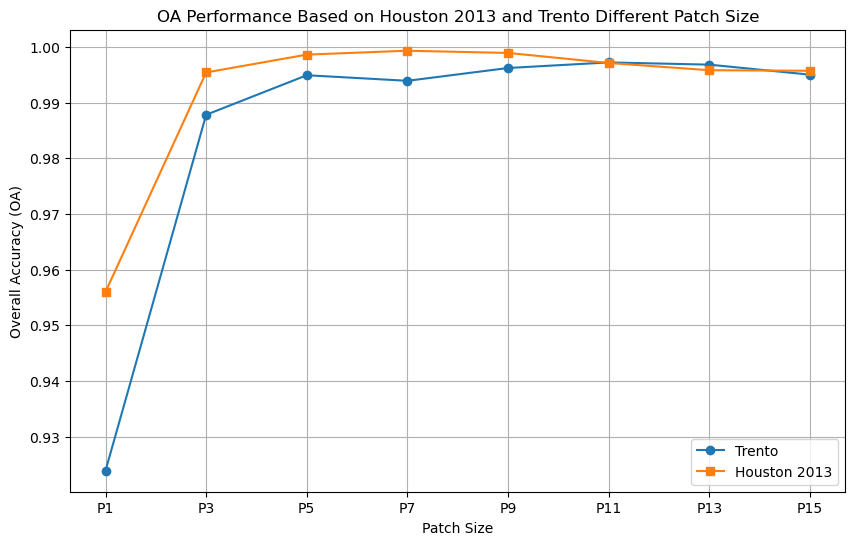

In [267]:
import matplotlib.pyplot as plt

# Data for the plot
patch_sizes = ['P1', 'P3', 'P5', 'P7', 'P9', 'P11', 'P13', 'P15']
trento_oa = [0.9239, 0.9878, 0.9949, 0.9939, 0.9962, 0.9972, 0.9968, 0.9950]
houston_oa = [0.956, 0.9954, 0.9986, 0.9993, 0.9989, 0.9971, 0.9958, 0.9957]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(patch_sizes, trento_oa, marker='o', label='Trento')
plt.plot(patch_sizes, houston_oa, marker='s', label='Houston 2013')

# Adding labels, title, and legend
plt.xlabel('Patch Size')
plt.ylabel('Overall Accuracy (OA)')
plt.title('OA Performance Based on Houston 2013 and Trento Different Patch Size')
plt.legend(loc='lower right')
plt.grid(True)

# Show plot
plt.show()
